In [ ]:
# default_exp interpret

In [ ]:
# hide
import sys

sys.path.append("..")

# Interpret

> Interpret the results of a model

In [ ]:
# export
from fastseq.all import *
from fastseq.data.external import *
from fastai2.basics import *
from fastseq.models.nbeats import *

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Need to pad 100/100 time series due to length.
Train:100; Valid: 600; Test 100


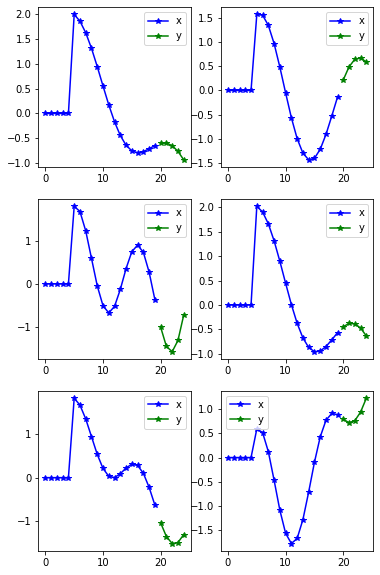

In [ ]:
items = dummy_data_generator(25, 10, nrows=100)
dbunch = TSDataBunch.from_items(items, horizon = 5)
dbunch.show_batch(max_n=6)

In [ ]:
learn = nbeats_learner(dbunch)

AssertionError: thetas_dim for BaisBlock must be 1, is now 3

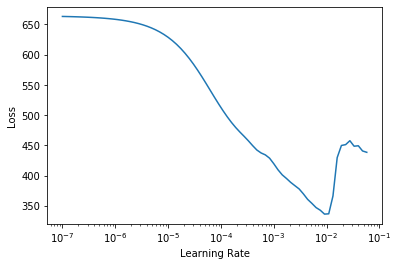

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,mae,smape,mse_loss,time
0,663.273621,1555669632.000000,18340.792969,92967.218750,1555669632.000000,00:00
1,383568.625000,729686592.000000,17268.666016,93095.140625,729686592.000000,00:00
2,818751.312500,81874896.000000,6094.781738,92936.515625,81874896.000000,00:00
3,653889.125000,7157875.500000,2006.556519,93027.625000,7157874.500000,00:00
4,521228.718750,4250939.000000,1533.985962,92971.882812,4250938.000000,00:00
5,435671.687500,813288.250000,686.855713,92855.265625,813287.250000,00:00
6,373553.406250,99193.617188,255.690659,92643.171875,99192.687500,00:00
7,325010.187500,16367.896484,111.051720,92290.554688,16366.976562,00:00
8,286715.281250,17048.267578,109.960739,92149.414062,17047.345703,00:00
9,256629.625000,25538.144531,127.672409,91972.296875,25537.226562,00:00


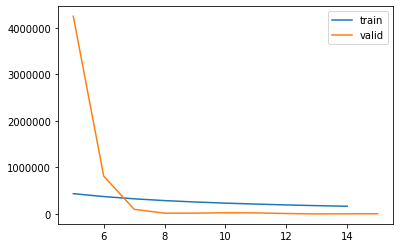

In [ ]:
learn.fit(15, .1)
learn.recorder.plot_loss()

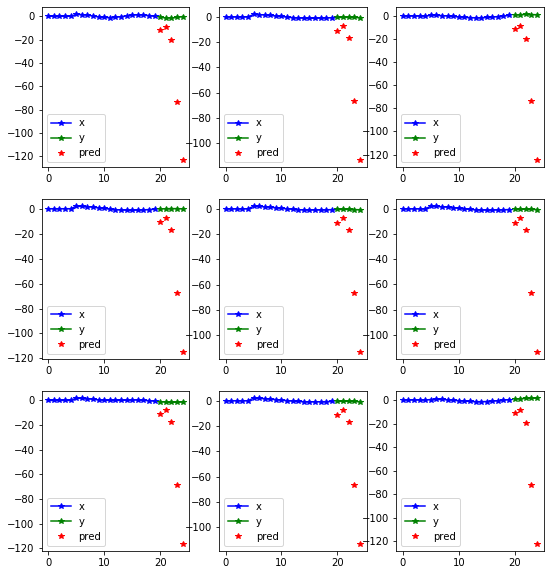

In [ ]:
learn.show_results(max_n=9)

In [ ]:
_ = learn.get_preds(dl=learn.dbunch.dls[1], with_input=True, with_loss=True, with_decoded=True, act=None)

In [ ]:
l_dct = learn.n_beats_trainer.out
[{block+'_'+name:l_dct[block][name].shape for name in l_dct[block]} for block in l_dct]

[{'trend0_b': torch.Size([600, 20]),
  'trend0_f': torch.Size([600, 5]),
  'trend0_theta': torch.Size([600, 4])},
 {'seaonality1_b': torch.Size([600, 20]),
  'seaonality1_f': torch.Size([600, 5]),
  'seaonality1_theta': torch.Size([600, 3])}]

In [ ]:
#hide
class NBeatsInterpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, dl, inputs, preds, targs, decoded, losses, dct = None):
        store_attr(self, "dl,inputs,preds,targs,decoded,losses,dct")

    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretatio object from a learner"
        if dl is None: dl = learn.dbunch.dls[ds_idx]
        res = learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)
        dct = learn.n_beats_trainer.out
        return cls(dl, *res, dct=dct)

    def top_losses(self, k=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)
    
    def plot_top_losses(self, k, largest=True, **kwargs):
        losses,idx = self.top_losses(k, largest)
        if not isinstance(self.inputs, tuple): self.inputs = (self.inputs,)
        if isinstance(self.inputs[0], Tensor): inps = tuple(o[idx] for o in self.inputs)
        else: inps = self.dl.create_batch(self.dl.before_batch([tuple(o[i] for o in self.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (self.targs if is_listy(self.targs) else (self.targs,)))
        x,y,its = self.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (self.decoded if is_listy(self.decoded) else (self.decoded,)))
        x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), self.preds[idx], losses,  **kwargs)
#         #TODO: figure out if this is needed
#         #its None means that a batch knos how to show itself as a whole, so we pass x, x1
#         else: 
#         show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

In [ ]:
#export
@typedispatch
def plot_top_losses(x:TSTensorSeq, y:TSTensorSeqy, *args, **kwargs):
    print(x.shape,y.shape, args)
    a = [(_x,TSTensorSeqy(_y, x_len = x.shape[-1], m = 'g'), TSTensorSeqy(pred,x_len = x.shape[-1], m = 'r'))
                for _x, _y, pred in zip(x, y, args[2])]
    show_graphs(a, titles=[str(o.data) for o in args[3]])
    

In [ ]:
from fastai2.interpret import *

In [ ]:
interp = _Interpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9)

In [ ]:
# hide
from nbdev.export import *

notebook2script()